# Graph accuracy vs. confidence

Graph model accuracy vs. confidence; precision-recall curve; display examples with top confidence

In [14]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from bms.chemistry import SmilesEvaluator, convert_smiles_to_canonsmiles


def lighten_color(color, amount=0.5): # https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

class Args:
    gold_file_syn = ["../data/molbank/pubchem/test_5k.csv",
                 "../data/molbank/pubchem/test_chemdraw_5k.csv",
                 "../data/molbank/uspto_test/uspto_indigo.csv",
                 "../data/molbank/uspto_test/uspto_chemdraw.csv"
                ]
    gold_file_real = ['../data/molbank/Img2Mol/CLEF.csv',
                 # '../data/molbank/Img2Mol/JPO.csv',
                 '../data/molbank/Img2Mol/UOB.csv',
                 '../data/molbank/Img2Mol/USPTO.csv',
                 '../data/molbank/Img2Mol/staker.csv',
                 '../data/molbank/real-acs-evaluation/acs.csv'
                ]
    pred_file_syn = ["../output/pubchem/synthetic/swin_base_200k_joint/prediction_test_5k.csv",
                 "../output/pubchem/synthetic/swin_base_200k_joint/prediction_test_chemdraw_5k.csv",
                 "../output/pubchem/synthetic/swin_base_200k_joint/prediction_uspto_indigo.csv",
                 "../output/pubchem/synthetic/swin_base_200k_joint/prediction_uspto_chemdraw.csv"
                 ]
    pred_file_real = ['../output/uspto/swin_base_aux_1m_ep25/prediction_CLEF.csv',
                 # '../output/uspto/swin_base_aux_1m_ep25/prediction_JPO.csv',
                 '../output/uspto/swin_base_aux_1m_ep25/prediction_UOB.csv',
                 '../output/uspto/swin_base_aux_1m_ep25/prediction_USPTO.csv',
                 '../output/uspto/swin_base_aux_1m_ep25/prediction_staker.csv',
                 '../output/uspto/swin_base_aux_1m_ep25/prediction_acs.csv'
                ]
    pred_field = "post_SMILES"
    acc_metric = "canon_smiles"
    score_field = "SMILES_score"
    # low = 0.8
    # high = 1.
    # step = 0.01
    low = 0.
    high = 1.
    step = 0.05
    verbose = False

def initialize(extra_args=None, data_type="real", reinit=True):
    global args, gold_df, pred_df, wrapper
    args = Args()
    if extra_args is not None:
        args.__dict__.update(extra_args)
    if reinit:
        gold_dfs = []
        pred_dfs = []
        gold_file = args.gold_file_real if data_type == "real" else args.gold_file_syn
        pred_file = args.pred_file_real if data_type == "real" else args.pred_file_syn
        total_so_far = 0
        for gdf_path, pdf_path in zip(gold_file, pred_file):
            gold_df = pd.read_csv(gdf_path)
            pred_df = pd.read_csv(pdf_path)
            if len(pred_df) != len(gold_df):
                print(f"Pred ({len(pred_df)}) and Gold ({len(gold_df)}) have different lengths!")
                # exit()
            image2goldidx = {image_id: idx for idx, image_id in enumerate(gold_df['image_id'])}
            image2predidx = {image_id: idx for idx, image_id in enumerate(pred_df['image_id'])}
            for image_id in gold_df['image_id']:
                if image_id not in image2predidx:
                    pred_df = pred_df.append({'image_id': image_id, args.pred_field: ""}, ignore_index=True)
            image2predidx = {image_id: idx for idx, image_id in enumerate(pred_df['image_id'])}
            pred_df = pred_df.reindex([image2predidx[image_id] for image_id in gold_df['image_id']])
            gold_df = gold_df.reindex([image2goldidx[image_id] for image_id in gold_df['image_id']])
            pred_df['new_idx'] = range(total_so_far, total_so_far+len(pred_df))
            gold_df['new_idx'] = range(total_so_far, total_so_far+len(pred_df))
            gold_df = gold_df.set_index('new_idx')
            pred_df = pred_df.set_index('new_idx')
            gold_dfs.append(gold_df)
            pred_dfs.append(pred_df)
            total_so_far += len(pred_df)

        gold_df = pd.concat(gold_dfs)
        pred_df = pd.concat(pred_dfs)

    wrapper = (lambda x: x) if args.verbose else tqdm

def compute_score(rows, field):
    if field in rows.index:
        return rows[field]
    if field == "SMILES_score":
        return rows[field]
    elif field == "edges_prod":
        return np.prod(np.array(eval(row["edges_token_scores"])))
    elif field == "twice_num_edges":
        return np.sum(np.array(eval(row["edges"])).astype(bool))
    elif field == "edges_score":
        return compute_score(row, "edges_prod") ** (1 / max(1, compute_score(row, "twice_num_edges")))
    elif field == "with_edges_score":
        score = row["SMILES_score"] * compute_score(row, "edges_score")
        try:
            assert abs(score - row["with_edges_score"]) < 1e-8
        except AssertionError:
            print(score, row["with_edges_score"])
        return row["with_edges_score"]
    elif field == "with_edges_prod":
        return row["SMILES_score"] * compute_score(row, "edges_prod")
    elif field == "atoms_score":
        token_scores = np.array(eval(row["SMILES_token_scores"]))
        indices = np.array(eval(row["indices"])) - 3
        return np.prod(token_scores[indices]) ** (1 / len(indices))
    elif field == "atoms_with_edges_score":
        return compute_score(row, "atoms_score") * compute_score(row, "edges_score")
    elif field == "atoms_with_edges_prod":
        return compute_score(row, "atoms_score") * compute_score(row, "edges_prod")
        

6it [00:10,  1.70s/it]
6it [00:18,  3.05s/it]


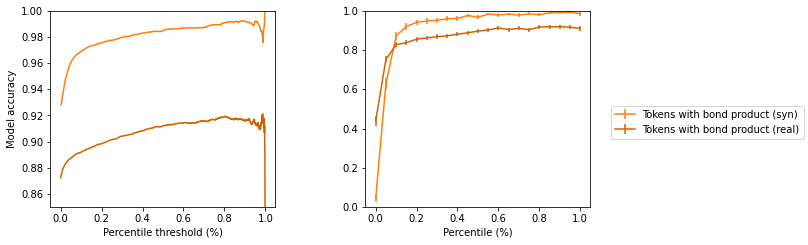

In [55]:
"""
DRAW MODEL ACCURACY VS. CONFIDENCE
"""

data_types = ["syn", "real"]
by_prctl = True  # x-axis is percentile for confidence
# extra_args_list = [{"score_field": "with_edges_score", "step": 0.005},
#                    {"score_field": "with_edges_prod", "step": 0.005},
#                    {"score_field": "SMILES_score", "step": 0.005},
#                    {"score_field": "atoms_with_edges_score", "step": 0.005},
#                    {"score_field": "atoms_with_edges_prod", "step": 0.005},
#                    {"score_field": "atoms_score", "step": 0.005}
#                   ]
# extra_args_list = [{"score_field": "with_edges_score", "step": 0.2},
#                    {"score_field": "with_edges_prod", "step": 0.2},
#                    {"score_field": "SMILES_score", "step": 0.2},
#                    {"score_field": "atoms_with_edges_score", "step": 0.2},
#                    {"score_field": "atoms_with_edges_prod", "step": 0.2},
#                    {"score_field": "atoms_score", "step": 0.2}
#                   ]
extra_args_list = [{"score_field": "with_edges_score", "step": 0.05},
                   {"score_field": "with_edges_prod", "step": 0.05},
                   {"score_field": "SMILES_score", "step": 0.05},
                   {"score_field": "atoms_with_edges_score", "step": 0.05},
                   {"score_field": "atoms_with_edges_prod", "step": 0.05},
                   {"score_field": "atoms_score", "step": 0.05}
                  ]
legend_names = ["Tokens with bonds", "Tokens with bond product", "Tokens without bonds", "Atoms with bonds", "Atoms with bond product", "Atoms without bonds"]
# save_fig = None
# save_fig = "conf_real.pdf"
indices = [1]
legend_names = [legend_name for i, legend_name in enumerate(legend_names) if i in indices]
save_fig = "figures/conf_both_prctl_50_twbp.pdf"
jump = 50

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12., 3.6))
# fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(right=0.75, wspace=0.4)
# fig.tight_layout()
# ax1.set_ylim([0.9, 1.01])
ax1.set_ylim([0.85, 1.])
if by_prctl:
    ax1.set_xlabel("Percentile threshold (%)")
else:
    ax1.set_xlabel("Confidence threshold")
ax1.set_ylabel(f"Model accuracy")
ax2.set_ylim([0., 1.])
if by_prctl:
    ax2.set_xlabel("Percentile (%)")
else:
    ax2.set_xlabel("Confidence level")
#ax1.set_ylabel(f"Model accuracy ({args.acc_metric})")
# if not by_prctl:
#     # only draws cdf for first metric
#     ax2 = ax1.twinx()
#     l2, = ax2.plot(conf_thres, prctg_pass, color='gray')
#     ax2.set_ylabel("Percentage above threshold (%)")
# ax2.set_ylim([-0.04, 1.04])
# if not by_prctl:
#     # plots pdf only for first metric
#     ax2 = ax1.twinx()
#     l2, = ax2.plot(conf, fraction_in, color='gray')
#     # ax2.hist(pred_df[args.score_field], bins=np.arange(args.low-args.step/2, args.high-args.step/2, args.step), color='gray')
#     ax2.set_ylabel(f"Percentage at confidence level (%)")
#plt.title("Model accuracy of test examples above confidence threshold")
labels = []
for k, data_type in enumerate(data_types):
    for i, extra_args in tqdm(enumerate(extra_args_list)):
        if indices is not None and i not in indices:
            continue
        initialize(extra_args, data_type)
        acc, acc_err = [], []
        total_len = len(pred_df)
        pred_df = pred_df.sort_values(args.score_field, ascending=False)
        gold_df = gold_df.reindex(index=pred_df.index)
        conf = pred_df[args.score_field]
        evaluator = SmilesEvaluator(gold_df['SMILES'])
        results = evaluator.evaluate(pred_df[args.pred_field], include_details=True)[args.acc_metric+'_details']
        cum_correct = np.cumsum(results)
        precision = cum_correct / np.arange(1, len(results)+1)
        tot_correct = np.sum(results)
        conf_thres = np.arange(len(results)-1, -1, -1) / len(results)
        ax1.plot(conf_thres[jump-1::jump], precision[jump-1::jump], color=lighten_color(f'C{i}', 1+0.25*k))
        last_cut_idx = max(0, round((1 - args.high - args.step/2) * total_len))
        conf = []
        for c in np.arange(args.high, args.low-args.step/2, -args.step):
            if args.verbose:
                if by_prctl:
                    print("Current percentile threshold: {:.4f}".format(c))
                else:
                    print("Current confidence threshold: {:.4f}".format(c))
            if by_prctl:
                cut_idx = min(round((1 - c + args.step/2) * total_len), total_len)
            else:
                cut_idx = last_cut_idx
                while cut_idx < len(gold_df) and conf[cut_idx] > c - args.step/2:
                    cut_idx += 1
            num_ex = cut_idx - last_cut_idx
            if not num_ex:
                if args.verbose:
                    print("    There are no predictions in this bin")
                continue
            conf.append(c)
            acc.append((cum_correct[cut_idx-1] - (0 if last_cut_idx == 0 else cum_correct[last_cut_idx-1])) / num_ex)
            acc_err.append(1.96 * np.sqrt(acc[-1] * (1-acc[-1]) / num_ex))
            last_cut_idx = cut_idx
            if args.verbose:
                print(f"    Number of examples: {num_ex}")

            if args.verbose:
                print("    Model accuracy: {:.4f}".format(acc[-1]))

            if cut_idx >= len(gold_df):
                if args.verbose:
                    print("    Predictions above this threshold don't exist")
                break

        labels.append(ax2.errorbar(conf, acc, yerr=acc_err, color=lighten_color(f'C{i}', 1+0.25*k)))

if len(data_types) > 1:
    new_legend_names = []
    for data_type in data_types:
        for legend_name in legend_names:
            new_legend_names.append(f"{legend_name} ({data_type})")
    legend_names = new_legend_names
fig.legend(labels, legend_names, loc=7)

if save_fig is not None:
    fig.savefig(save_fig)
plt.show()

6it [01:32, 15.35s/it]


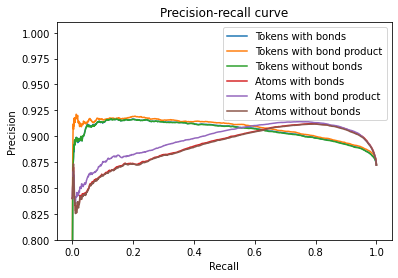

In [46]:
"""
PRECISION-RECALL CURVE
"""

data_type = "real"
# extra_args_list = [{"score_field": "with_edges_score", "low": 0.8, "high": 1., "step": 0.03},
#                    {"score_field": "with_edges_prod", "low": 0.8, "high": 1., "step": 0.03},
#                    {"score_field": "SMILES_score", "low": 0.8, "high": 1., "step": 0.03},
#                    {"score_field": "atoms_with_edges_score", "low": 0.8, "high": 1., "step": 0.03},
#                    {"score_field": "atoms_with_edges_prod", "low": 0.8, "high": 1., "step": 0.03},
#                    {"score_field": "atoms_score", "low": 0.8, "high": 1., "step": 0.03}
#                   ]
extra_args_list = [{"score_field": "with_edges_score", "low": 0.8, "high": 1., "step": 0.001},
                   {"score_field": "with_edges_prod", "low": 0.8, "high": 1., "step": 0.001},
                   {"score_field": "SMILES_score", "low": 0.8, "high": 1., "step": 0.001},
                   {"score_field": "atoms_with_edges_score", "low": 0.8, "high": 1., "step": 0.001},
                   {"score_field": "atoms_with_edges_prod", "low": 0.8, "high": 1., "step": 0.001},
                   {"score_field": "atoms_score", "low": 0.8, "high": 1., "step": 0.001}
                  ]
# extra_args_list = [{"score_field": "with_edges_score", "low": 0.8, "high": 1., "step": 0.001}]
legend_names = ["Tokens with bonds", "Tokens with bond product", "Tokens without bonds", "Atoms with bonds", "Atoms with bond product", "Atoms without bonds"]
# legend_names = ["Tokens with bond product"]
save_fig = "prc_real_50.pdf"
# save_fig = "prc_syn_twbp_50.svg"
# save_fig = None

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([-0.05, 1.05])
# plt.ylim([0.9, 1.01])
plt.ylim([0.8, 1.01])
jump = 50
# plt.ylim([0.895, 1.005])
for i, extra_args in tqdm(enumerate(extra_args_list)):
    initialize(extra_args, data_type, reinit=(i == 0))
    assert len(pred_df) == len(gold_df)
    pred_df = pred_df.sort_values(args.score_field, ascending=False)
    gold_df = gold_df.reindex(pred_df.index)
    evaluator = SmilesEvaluator(gold_df['SMILES'])
    results = evaluator.evaluate(pred_df[args.pred_field], include_details=True)[args.acc_metric+'_details']
    conf = pred_df[args.score_field]
    cum_correct = np.cumsum(results)
    precision = cum_correct / np.arange(1, len(results)+1)
    tot_correct = np.sum(results)
    recall = cum_correct / tot_correct
    plt.plot(recall[jump-1::jump], precision[jump-1::jump], label=legend_names[i])

plt.legend()

if save_fig is None:
    plt.show()
else:
    plt.savefig(save_fig)

1
CONFIDENCE: 0.9441675990803772
PATH: data/molbank/Img2Mol/staker/images/28366.png
GOLD: [R15]C([R16])([R17])[R18]
GOLD SUB: [15*]C([16*])([17*])[18*]
GRAPH: [16*]C([17*])([18*])C
PRED: [16*]C([17*])([18*])C
SYMBOLS: ["[16*]","C","[17*]","[18*]","C"]

(256, 256, 3)
GOLD:


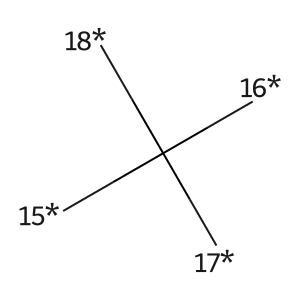

GRAPH:


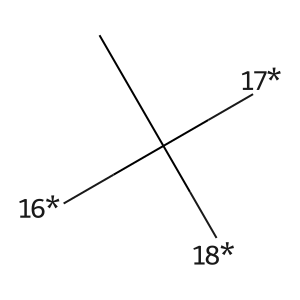

POST:


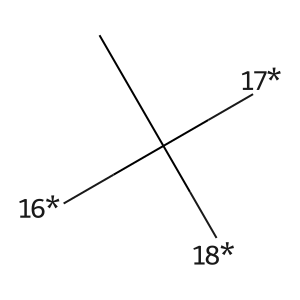

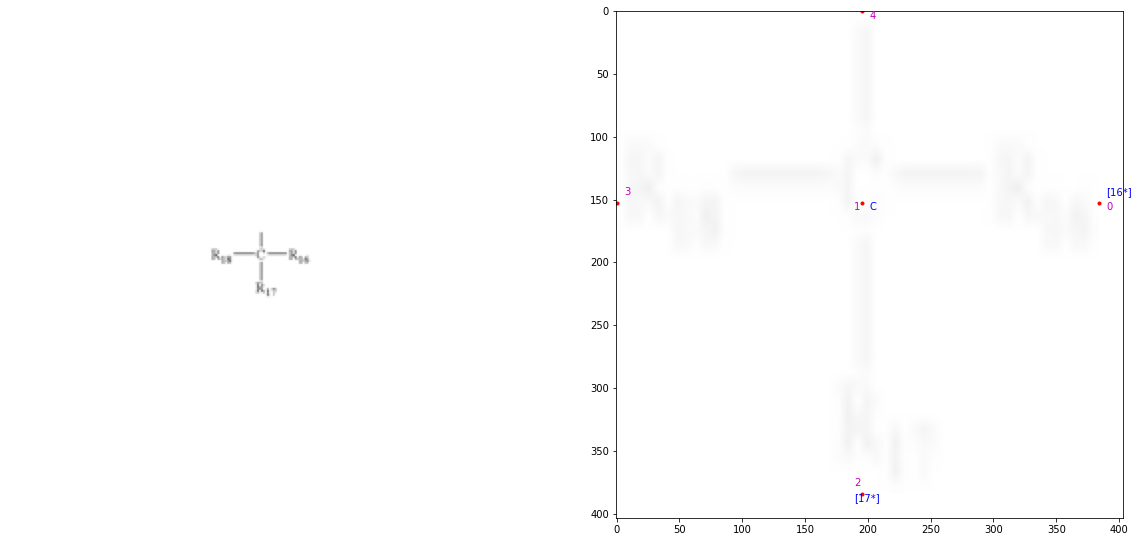

5
CONFIDENCE: 0.9381372488773458
PATH: data/molbank/Img2Mol/staker/images/29391.png
GOLD: [R2]O[Si]([R2O])([R3])O[R2]
[R2O] [O][2*]
GOLD SUB: [2*]O[Si]([O][2*])([3*])O[2*]
GRAPH: *[Si]([3*])(O[2*])O[2*]
PRED: *[Si]([3*])(O[2*])O[2*]
SYMBOLS: ["*","[Si]","[3*]","[OR2]","[OR2]"]

(256, 256, 3)
GOLD:
[R2O] [O][2*]


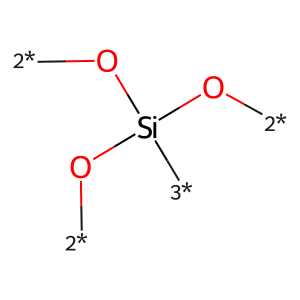

GRAPH:


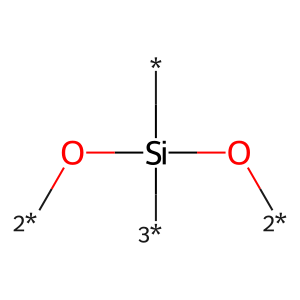

POST:


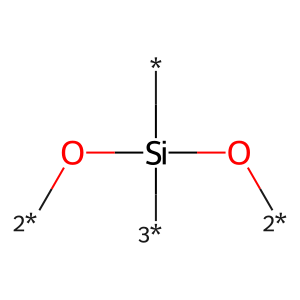

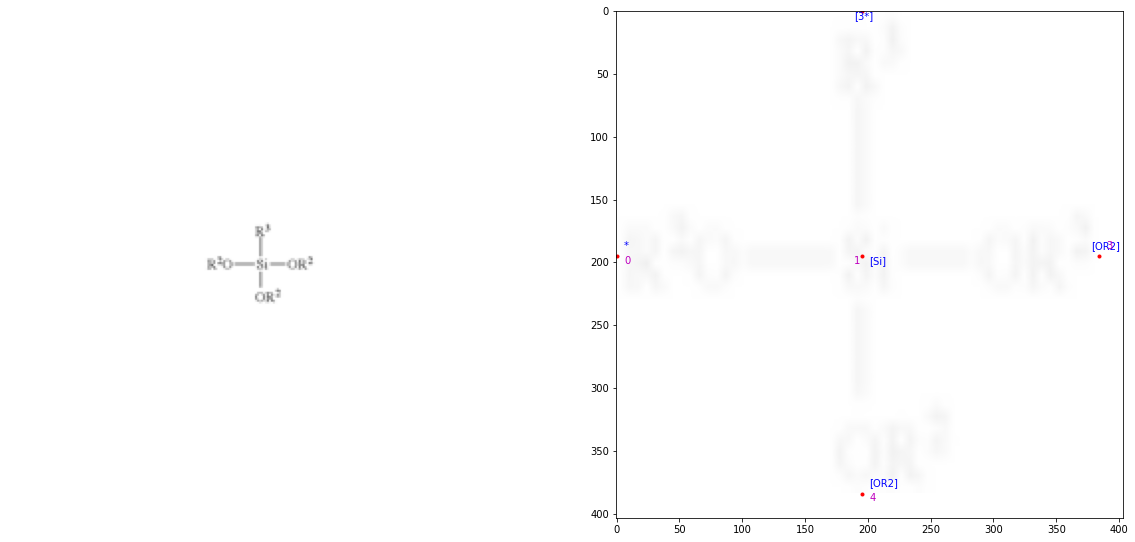

11
CONFIDENCE: 0.9334430770775068
PATH: data/molbank/Img2Mol/staker/images/45355.png
GOLD: C[R7]C1([R11])C2([R12])OC2([R13])C([R14])([R15])C([R16])([R17])C1([R18])[R19]
GOLD SUB: C[7*]C1([11*])C2([12*])OC2([13*])C([14*])([15*])C([16*])([17*])C1([18*])[19*]
GRAPH: [11*]C1(C)C([18*])([19*])C([16*])([17*])C([14*])([15*])C2([13*])OC12[12*]
PRED: [11*]C1(C)C([18*])([19*])C([16*])([17*])C([14*])([15*])C2([13*])OC12[12*]
SYMBOLS: ["[11*]","C","C","C","[12*]","O","C","[13*]","C","[14*]","[15*]","C","[16*]","[17*]","C","[18*]","[19*]"]

(256, 256, 3)
GOLD:


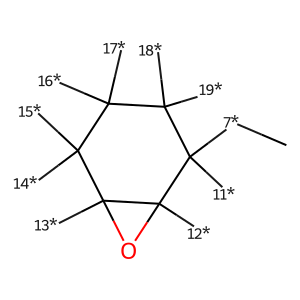

GRAPH:


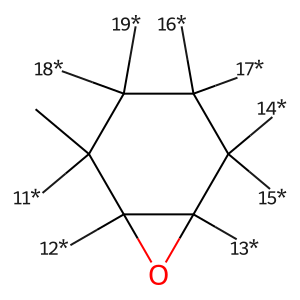

POST:


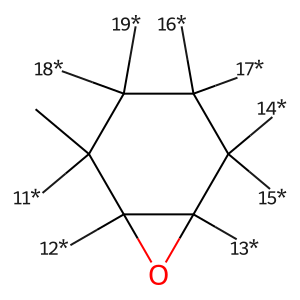

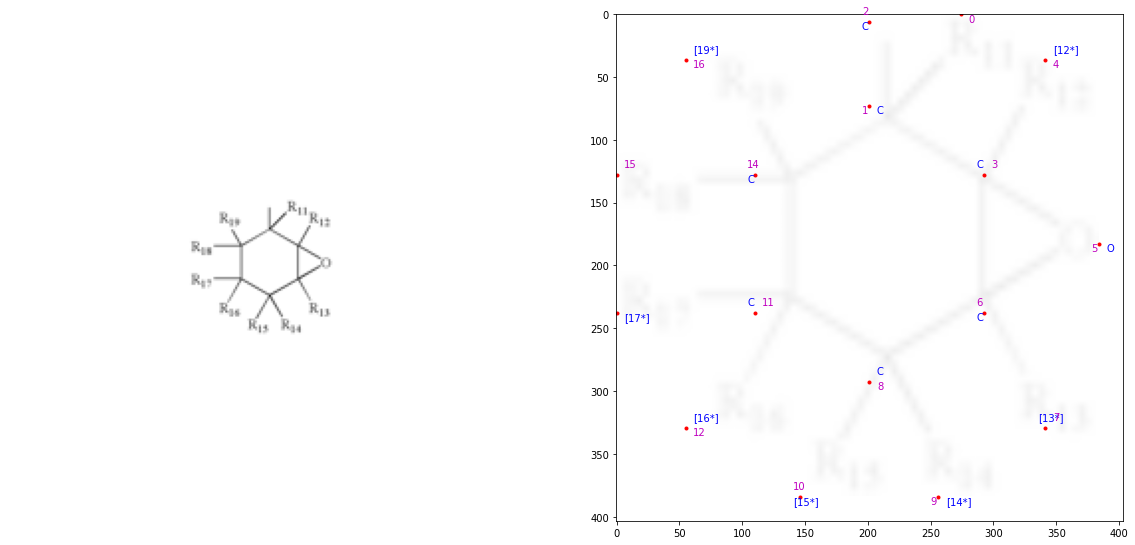

22
CONFIDENCE: 0.9282332646495072
PATH: data/molbank/Img2Mol/staker/images/2852.png
GOLD: I[R1][Si]([R2])([R3])[R4]
GOLD SUB: I[1*][Si]([2*])([3*])[4*]
GRAPH: [3*][Si]([4*])(C)[1*]I
PRED: [3*][Si]([4*])(C)[1*]I
SYMBOLS: ["[3*]","[Si]","[4*]","C","[1*]","I"]

(256, 256, 3)
GOLD:


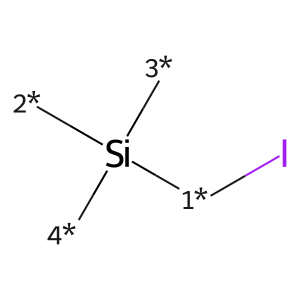

GRAPH:


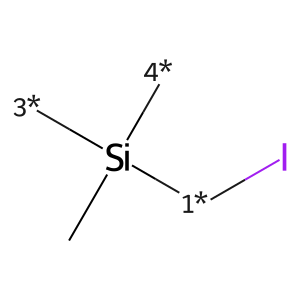

POST:


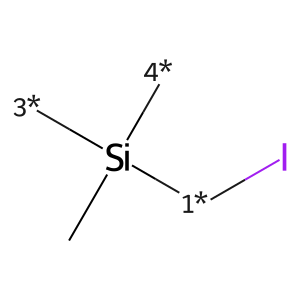

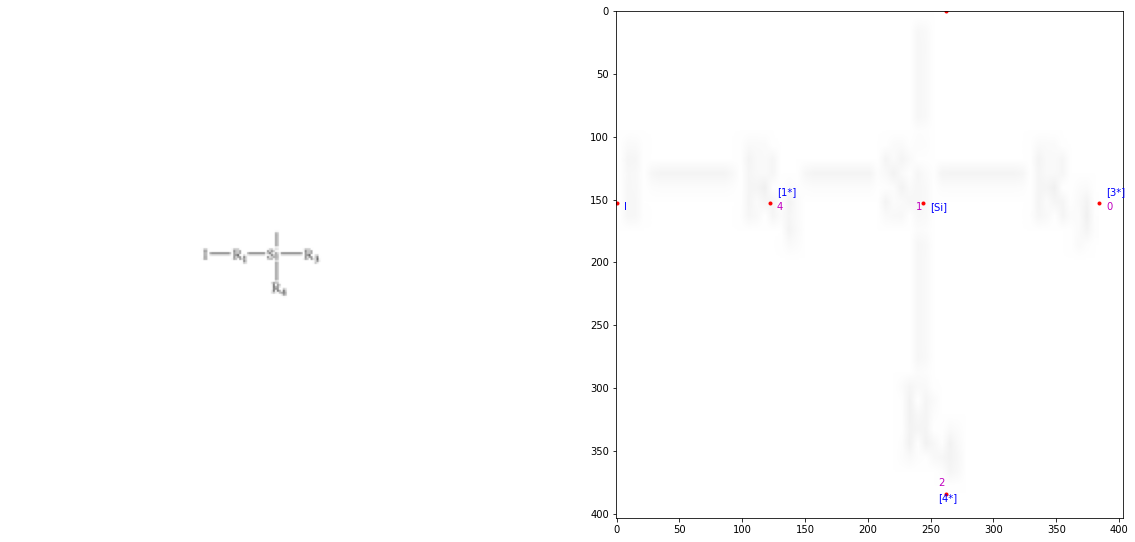

24
CONFIDENCE: 0.9280749973806004
PATH: data/molbank/Img2Mol/staker/images/46794.png
GOLD: [O-][N+]([R8])=C([R6])[R7]
GOLD SUB: [O-][N+]([8*])=C([6*])[7*]
GRAPH: [6*]C([7*])=N([8*])O
PRED: [6*]C([7*])=N([8*])O
SYMBOLS: ["[6*]","C","[7*]","N","[8*]","O"]

(256, 256, 3)
GOLD:


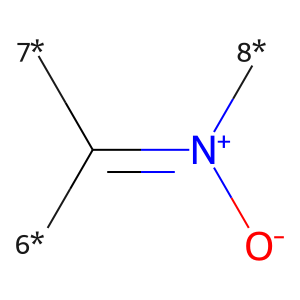

GRAPH:


ValueError: Null molecule provided

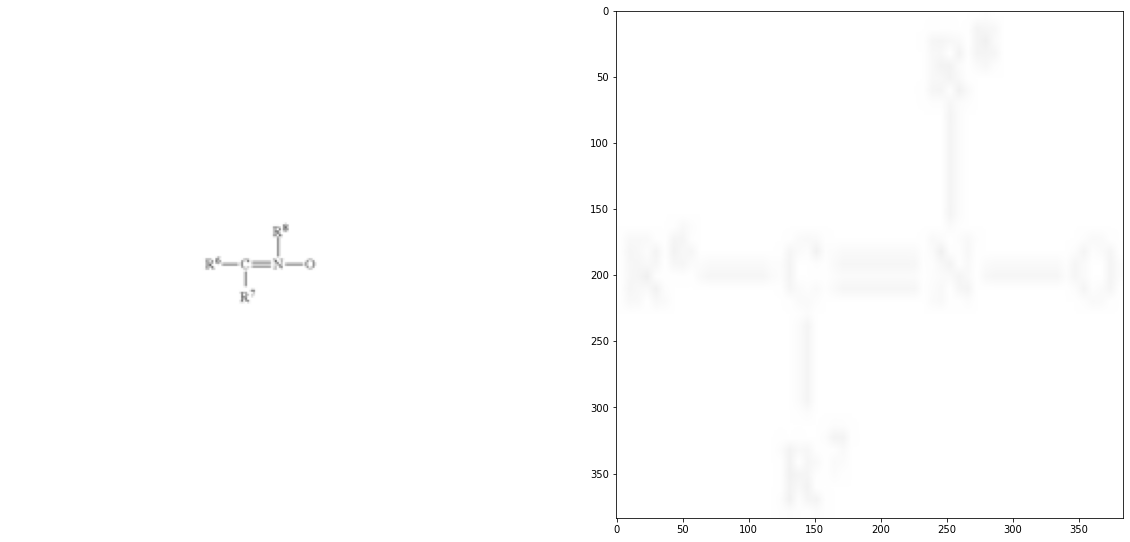

In [21]:
"""
SHOW EXAMPLES WITH TOP CONFIDENCE SCORES
"""

import cv2
from bms.augment import CropWhite
import albumentations as A
import rdkit.Chem as Chem
from bms.chemistry import _sub_condensed

data_type = "real"
extra_args = {"score_field": "SMILES_score"}
reinit = False
draw_graph = True
if reinit:
    initialize(extra_args, data_type)
    assert len(pred_df) == len(gold_df)
    pred_df = pred_df.sort_values(args.score_field, ascending=False)
    gold_df = gold_df.reindex(pred_df.index)
    evaluator = SmilesEvaluator(gold_df['SMILES'])
    results = evaluator.evaluate(pred_df[args.pred_field], include_details=True)[args.acc_metric+'_details']
    conf = pred_df[args.score_field]

# print(results[:1000])
for i in range(1000):
    if results[i]:
        continue
    print(i)
    # print("SUCCESS:", results[i])
    print("CONFIDENCE:", conf.iloc[i])
    print("PATH:", gold_df.iloc[i]['file_path'])
    print("GOLD:", gold_df.iloc[i]['SMILES'])
    print("GOLD SUB:", _sub_condensed(gold_df.iloc[i]['SMILES']))
    print("GRAPH:", pred_df.iloc[i]['graph_SMILES'])
    print("PRED:", pred_df.iloc[i]['post_SMILES'])
    print("SYMBOLS:", pred_df.iloc[i]['node_symbols'])
    # print("SYMB:", pred_df.iloc[i]['node_symbols'])
    print("")
    if draw_graph:
        # PLOT ORIGINAL
        path = '../' + gold_df.iloc[i]['file_path']
        img = cv2.imread(path)
        print(img.shape)
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        # plt.subplot(1,1,1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(1,2,2)
        transform = A.Compose([CropWhite(pad=0), A.Resize(384,384)])
        img = transform(image=img)['image']
        plt.imshow(img, alpha=0.1)
        print("GOLD:")
        mol = Chem.MolFromSmiles(_sub_condensed(gold_df.iloc[i]['SMILES']))
        display(Chem.Draw.MolToImage(mol))
        print("GRAPH:")
        mol = Chem.MolFromSmiles(pred_df.iloc[i]['graph_SMILES'])
        display(Chem.Draw.MolToImage(mol))
        print("POST:")
        mol = Chem.MolFromSmiles(pred_df.iloc[i]['post_SMILES'])
        display(Chem.Draw.MolToImage(mol))
#     smiles_token_scores = eval(nodes_pred_df.loc[i, 'SMILES_token_scores'])
#     edges_token_scores = eval(nodes_pred_df.loc[i, 'edges_token_scores'])
        # PLOT ATOMS
        h, w, _ = img.shape
        delta = 6
        DIR = [(delta, -delta), (delta, delta), (-delta, delta), (-delta, -delta)]
        symbols = np.array(eval(pred_df.iloc[i]['node_symbols']))
        coords = np.array(eval(pred_df.iloc[i]['node_coords']))
        x, y = coords[:,0]*w, coords[:,1]*h
        plt.scatter(x, y, color='r', marker='.')
        for idx, (xi, yi, symb) in enumerate(zip(x, y, symbols)):
            plt.annotate(symb, (xi+DIR[idx%4][0], yi+DIR[idx%4][1]), color='blue')
            plt.annotate(idx, (xi+DIR[(idx+1)%4][0], yi+DIR[(idx+1)%4][1]), color='m')
            # plt.annotate(bad_tokens[idx], (xi+DIR[(idx+2)%4][0], yi+DIR[(idx+2)%4][1]), color='c')
        plt.show()

#     # PLOT BONDS
#     edges = eval(nodes_pred_df.loc[i, 'edges'])
#     post_smiles, mol, post_success = _postprocess_smiles(pred_smiles, coords, symbols, edges, debug=True)
#     for i in range(len(x)):
#         for j in range(len(x)):
#             if edges_token_scores[i][j] < 0.995:
#                 plt.annotate('E{:.3f}'.format(edges_token_scores[i][j]), ((x[i]+x[j])/2, (y[i]+y[j])/2), color='y')
#                 if verbose and i <= j:
#                     print(f'EDGE\t{i}\t{j}\t{edges_token_scores[i][j]}\tE')
#             elif verbose and edges[i][j] != 0 and i <= j:
#                 print(f'EDGE\t{i}\t{j}\t{edges_token_scores[i][j]}')
#             if edges[i][j] != 0:
#                 if edges[i][j] in [5, 6]:
#                     color = 'blue' if edges[i][j] == 5 else 'green'
#                     plt.arrow(x[i], y[i], x[j]-x[i], y[j]-y[i], color=color, head_width=5)
# #                     print(i, j, edges[i][j], edges[j][i])
#                 else:
#                     if edges[i][j] == 1:
#                         color = 'red'
#                     elif edges[i][j] == 2:
#                         color = 'orange'
#                     else:
#                         color = 'yellow'
#                     plt.plot([x[i], x[j]], [y[i], y[j]], color)


In [ ]:
from bms.chemistry import convert_smiles_to_canonsmiles

data_type = "synthetic"
extra_args_list = [
                   {"score_field": "atoms_with_edges_prod", "step": 0.001}
                  ]
# legend_names = ["Tokens with bonds", "Tokens with bond product", "Tokens without bonds", "Atoms with bonds", "Atoms with bond product", "Atoms without bonds"]
# save_fig = "acc_hist_syn.pdf"
save_fig = None

# plt.title("ROC curve")
plt.xlabel("Model accuracy")
plt.ylabel("Frequency")
bins = np.arange(0., 1., 0.05)
right, wrong = [], []
for i, extra_args in enumerate(extra_args_list):
    initialize(extra_args, data_type)
    for gold_smiles, pred_smiles, c in wrapper(zip(gold_df['SMILES'], pred_df[args.pred_field], pred_df[args.score_field])):
        gold_smiles = convert_smiles_to_canonsmiles(gold_smiles, ignore_cistrans=True)
        pred_smiles = convert_smiles_to_canonsmiles(pred_smiles, ignore_cistrans=True)
        if gold_smiles == pred_smiles:
            right.append(c)
        else:
            wrong.append(c)

plt.hist(right, bins=bins, label="Correct prediction")
plt.hist(wrong, bins=bins, label="Wrong prediction")
plt.legend()

if save_fig is None:
    plt.show()
else:
    plt.savefig(save_fig)

333it [08:03,  1.46s/it]

In [12]:
from SmilesPE.pretokenizer import atomwise_tokenizer
from bms.chemistry import _condensed_formula_to_smiles, _get_num_bonds

def _sub_condensed(smiles):
    tokens = atomwise_tokenizer(smiles)
    print(tokens)
    for j, token in enumerate(tokens):
        if token[0] == '[' and token[-1] == ']' and Chem.AtomFromSmiles(token) is None:
            sub_smiles, _, _, _, success = _condensed_formula_to_smiles(token[1:-1], _get_num_bonds(tokens, j))
            print(sub_smiles)
            if success:
                tokens[j] = sub_smiles
    return ''.join(tokens)

print(_sub_condensed("[R2][R1][N+]([R3][R4])([R5][R5])[R7][R8]"))

['[R2]', '[R1]', '[N+]', '(', '[R3]', '[R4]', ')', '(', '[R5]', '[R5]', ')', '[R7]', '[R8]']
[2*]
[1*]
[3*]
[4*]
[5*]
[5*]
[7*]
[8*]
[2*][1*][N+]([3*][4*])([5*][5*])[7*][8*]
